In [13]:
# Importing the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import random

In [14]:
# Load the dataset
dataset = pd.read_csv(r'input/data/240624_validation_data.csv')

# Extract the time, forecasted demand and actual demand
time = dataset['time']
time = pd.to_datetime(time, utc=True)
forecast_demand = dataset['predicted heat']
actual_demand = dataset['delivered heat']

# Create a dataframe
df_data = pd.DataFrame({'time' : time, 'actual_demand': actual_demand, 'forecast_demand': forecast_demand})
df_data['hour']=time.dt.hour

# Calculate the error and absolute error
df_data['error']= df_data['actual_demand'] - df_data['forecast_demand']

# Calculate the mean of the error for whole dataset
mu_all = df_data['error'].mean()
sigma_all = df_data['error'].std()
print('Mean of the mean of the error of each hour:', mu_all)
print('Standard deviation of the mean of the error of each hour:', sigma_all)

Mean of the mean of the error of each hour: -8.39020298257356
Standard deviation of the mean of the error of each hour: 31.42172005784749


In [15]:
# Select the date for which you want to extract the data
selected_date = '2023-04-01'

# Number of scenarios
num_scenarios = 10

# Extract the data for the selected date
daily_date = df_data[df_data['time'].dt.date == pd.to_datetime(selected_date).date()].reset_index(drop=True)
daily_date = daily_date[['time', 'hour', 'actual_demand', 'forecast_demand', 'error']]
if(len(daily_date)==24):
    print('The selected date has 24 hours')
else:
    print('The selected date does not have 24 hours')

daily_date

The selected date has 24 hours


,time,hour,actual_demand,forecast_demand,error
0,2023-04-01 00:00:00+00:00,0,45.141668,79.256436,-34.114768
1,2023-04-01 01:00:00+00:00,1,71.408335,88.850384,-17.442050
2,2023-04-01 02:00:00+00:00,2,234.970838,166.624694,68.346144
3,2023-04-01 03:00:00+00:00,3,146.212502,113.137177,33.075326
4,2023-04-01 04:00:00+00:00,4,131.770836,118.939521,12.831315
5,2023-04-01 05:00:00+00:00,5,129.470836,124.614834,4.856001
6,2023-04-01 06:00:00+00:00,6,160.633337,125.941581,34.691755
7,2023-04-01 07:00:00+00:00,7,168.050002,118.988194,49.061808
8,2023-04-01 08:00:00+00:00,8,162.475003,113.102637,49.372366
9,2023-04-01 09:00:00+00:00,9,96.350001,103.574392,-7.224391


---

## First Methode

In [16]:
# Calculate the mean and standard deviation of the error of each hour
error = df_data.groupby('hour')['error'].agg(['mean', 'std']).reset_index()
error  = error.rename(columns={'mean': 'mu', 'std': 'sigma'})

In [25]:
# Generate scenarios for the selected date
forecast_demand = daily_date['forecast_demand']

scenarios = np.zeros((num_scenarios, 24))

for i in range(24):
    mu = error.loc[error['hour'] == i, 'mu'].values[0]
    sigma = error.loc[error['hour'] == i, 'sigma'].values[0]

    hourly_scenarios = np.random.normal(mu, sigma, num_scenarios)

    scenarios[:, i] = forecast_demand[i] + hourly_scenarios

scenarios_df = pd.DataFrame(scenarios)


# Calculate the probability for each scenario
probabilities = stats.norm(mu_all, sigma_all).pdf(scenarios - forecast_demand.values.reshape(1, -1))
probabilities = probabilities.prod(axis=1)

# Add the probabilities to the scenarios dataframe
scenarios_df['probability'] = probabilities
scenarios_df
probabilities

array([2.05418439e-49, 1.03240308e-51, 6.76259609e-50, 2.36972152e-53,
       2.82215680e-51, 2.80406264e-51, 2.66504623e-51, 6.09349277e-53,
       6.08901396e-52, 6.16151545e-51])

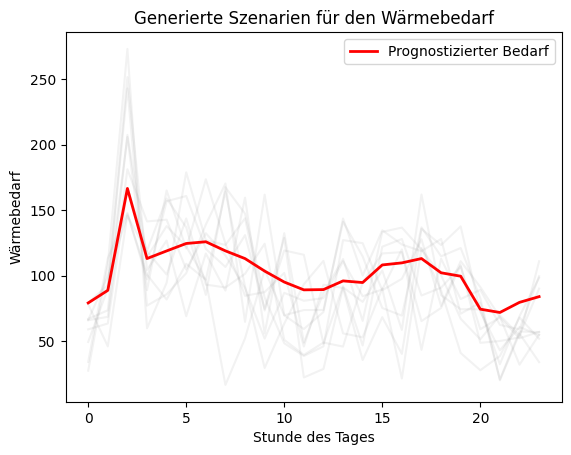

In [18]:
plt.plot(scenarios.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

---

## Second Methode: Monte Carlo Sampling and Roulette Wheel Mechanism


In [19]:
# number of intervals
num_intervals = 7  
intervals = np.linspace(mu_all - 3*sigma_all, mu_all + 3*sigma_all, 8)
interval_centers = (intervals[:-1] + intervals[1:]) / 2  
print('Intervals:',intervals)
print('Interval Centers:',interval_centers)

# calculate the probabilities
probabilities = [stats.norm.cdf(intervals[i+1], mu_all, sigma_all) - stats.norm.cdf(intervals[i], mu_all, sigma_all) for i in range(len(intervals)-1)]
cum_probabilities = np.cumsum(probabilities)

# print the probabilities
print('Probabilities:',probabilities)
print('Edge on Scale 0.XX-0.99X Probabilities:',cum_probabilities)

# Function to randomly select an interval based on the CDF

def select_interval(cumulative_probabilities):
    rnd = random.random()
    for i, cp in enumerate(cumulative_probabilities):
        if rnd <= cp:
            return i
    return len(cumulative_probabilities) - 1


Intervals: [-102.65536316  -75.72246025  -48.78955734  -21.85665444    5.07624847
   32.00915138   58.94205428   85.87495719]
Interval Centers: [-89.1889117  -62.2560088  -35.32310589  -8.39020298  18.54269992
  45.47560283  72.40850574]
Probabilities: [0.014712387572198223, 0.08320911123950271, 0.2348461740542938, 0.33176485820475055, 0.23484617405429364, 0.0832091112395027, 0.014712387572198171]
Edge on Scale 0.XX-0.99X Probabilities: [0.01471239 0.0979215  0.33276767 0.66453253 0.89937871 0.98258782
 0.9973002 ]


In [20]:
# Generate scenarios
T = 24  # Number of time steps
scenarios = []

for _ in range(num_scenarios):
    scenario = []
    for t in range(T):
        interval_index = select_interval(cum_probabilities)
        scenario.append(interval_centers[interval_index])
    scenarios.append(scenario)

    
# Calculate normed probability for each scenario
scenario_probabilities = np.prod([[probabilities[select_interval(cum_probabilities)] for _ in range(T)] for _ in range(num_scenarios)], axis=1)
normalized_probabilities = scenario_probabilities / scenario_probabilities.sum()

# Convert scenarios to DataFrame for better visualization
scenarios_mu_df = pd.DataFrame(scenarios, columns=[f'Time_{t}' for t in range(T)])
probabilities_df = pd.DataFrame(normalized_probabilities, columns=['Probability'])


In [21]:
probabilities_df


,Probability
0,0.148695
1,0.000002
2,0.000009
3,0.003318
4,0.006601
5,0.838444
6,0.000292
7,0.000208
8,0.002327
9,0.000104


In [22]:
# Add the predicted thermal demand to the error scenarios to get the actual thermal demand scenarios
scenarios_df = scenarios_mu_df.apply(lambda row: daily_date['forecast_demand'] + row.values, axis=1)

# Create csv file for the scenarios
scenarios_df.to_csv('output/scenarios.csv', index=False)

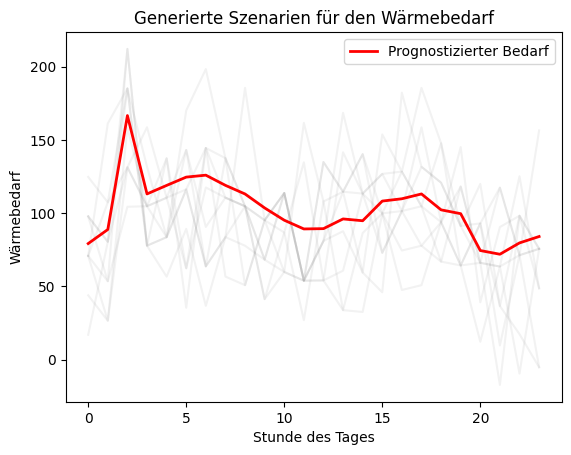

In [23]:
plt.plot(scenarios_df.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

## Szenarien Reduktion

In [24]:
# Importing the libraries

from sklearn.cluster import KMeans
from scipy.stats import entropy

### Backward Scenario Reduction Methode
Ergänzen.

### Improved k-means Clustering

Ergänzen.